In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Data transformations: Include augmentation for contrastive learning
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Use a subset of 1,000 images
subset_indices = list(range(1000))  # First 1,000 samples
small_dataset = torch.utils.data.Subset(dataset, subset_indices)

# DataLoader for batching
data_loader = DataLoader(small_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [2]:
for i in small_dataset:
    print(i[0].shape)
    break

torch.Size([3, 32, 32])


In [3]:
for batch in data_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


# Test Augmentations

In [4]:
from aug import *

## Random Apply

In [5]:
# Define a simple function to apply
def add_noise(tensor):
    return tensor + torch.randn_like(tensor) * 0.1

# Input tensor
x = torch.ones((3, 3))

# Apply with 50% probability
result = random_apply(add_noise, p=1, x=x)

print("Original Tensor:\n", x)
print("Transformed Tensor:\n", result)

Original Tensor:
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Transformed Tensor:
 tensor([[1.0678, 1.0629, 1.0762],
        [1.0455, 1.0450, 0.8065],
        [1.0088, 1.0830, 0.9251]])


## Random Brightness

In [6]:
# Example image tensor (normalized values in [0, 1])
image = torch.rand((3, 224, 224))

# Apply random brightness (SimCLRv2 version)
adjusted_image_v2 = random_brightness(image, max_delta=0.2)

print("Original Image Mean Brightness:", image.mean().item())
print("Adjusted Image Mean Brightness:", adjusted_image_v2.mean().item())

Original Image Mean Brightness: 0.49967676401138306
Adjusted Image Mean Brightness: 0.4151829481124878


## Gray Scale

In [7]:
# Example RGB image tensor with shape (3, H, W), normalized in [0, 1]
image = torch.rand((3, 224, 224))

# Convert to grayscale and keep channels
grayscale_image = to_grayscale(image, keep_channels=True)

# Convert to grayscale without keeping channels
single_channel_image = to_grayscale(image, keep_channels=False)

print("Original Image Shape:", image.shape)
print("Grayscale Image Shape (Keep Channels):", grayscale_image.shape)
print("Grayscale Image Shape (Single Channel):", single_channel_image.shape)

Original Image Shape: torch.Size([3, 224, 224])
Grayscale Image Shape (Keep Channels): torch.Size([3, 224, 224])
Grayscale Image Shape (Single Channel): torch.Size([224, 224])


## Color Gitter

In [8]:
# Example input tensor (normalized in [0, 1])
image = torch.rand((3, 224, 224))  # Example RGB image

# Apply color jitter with strength 0.5
augmented_image = color_jitter(image, strength=0.5, random_order=True)

print("Original Image Mean:", image.mean().item())
print("Augmented Image Mean:", augmented_image.mean().item())

Original Image Mean: 0.5017236471176147
Augmented Image Mean: 0.30731314420700073


## Crop and Resize

In [9]:
# Example image (3x224x224)
image = torch.rand(3, 224, 224)  # Simulated input image (normalized to [0, 1])

# Center crop
center_cropped = center_crop(image, height=200, width=200, crop_proportion=0.8)

# Random crop and resize
cropped_resized = crop_and_resize(image, height=128, width=128)

print("Original Image Shape:", image.shape)
print("Center Cropped Shape:", center_cropped.shape)
print("Cropped and Resized Shape:", cropped_resized.shape)

Original Image Shape: torch.Size([3, 224, 224])
Center Cropped Shape: torch.Size([3, 200, 200])
Cropped and Resized Shape: torch.Size([3, 128, 128])


## Gaussian Blur

In [10]:
# Example image [C, H, W] (3 channels, 224x224)
image = torch.rand(3, 224, 224)

# Apply Gaussian blur
kernel_size = 5
sigma = 1.5
blurred_image = gaussian_blur(image, kernel_size=kernel_size, sigma=sigma, padding='same')

print("Original Image Shape:", image.shape)
print("Blurred Image Shape:", blurred_image.shape)

Original Image Shape: torch.Size([3, 224, 224])
Blurred Image Shape: torch.Size([3, 224, 224])


In [11]:
# Example batch of images [B, C, H, W] (batch size B, 3 channels, 224x224)
batch_images = torch.rand(8, 3, 224, 224)

# Apply batch random blur
blurred_images = batch_random_blur([batch_images], height=224, width=224, blur_probability=0.5)

print("Original Image Shape:", batch_images.shape)
print("Processed Image Shape:", blurred_images[0].shape)

Original Image Shape: torch.Size([8, 3, 224, 224])
Processed Image Shape: torch.Size([8, 3, 224, 224])


# Network

## Viualizing Data

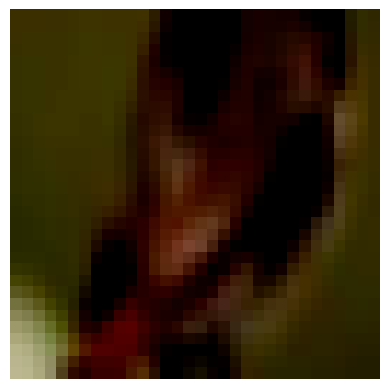

In [12]:
import matplotlib.pyplot as plt

# Ensure the tensor is on CPU and permute to HWC format
preprocessed_image = batch[0][0,:,:,:].permute(1,2,0).cpu().numpy()

# Normalize the image to the range [0, 1]
preprocessed_image = np.clip(preprocessed_image, 0, 1)

# Plot the image
plt.imshow(preprocessed_image)
plt.axis('off')  # Hide the axis
plt.show()

In [13]:
preprocessed_image = preprocess_for_train(batch[0][0,:,:,:], height=32, width=32, color_distort=True, crop=True, flip=True)

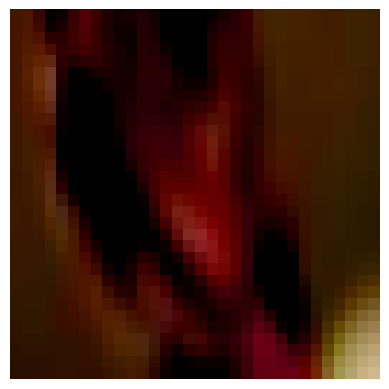

In [14]:
import matplotlib.pyplot as plt

# Ensure the tensor is on CPU and permute to HWC format
preprocessed_image = preprocessed_image.cpu().numpy()

# Normalize the image to the range [0, 1]
preprocessed_image = np.clip(preprocessed_image, 0, 1)

# Plot the image
plt.imshow(preprocessed_image)
plt.axis('off')  # Hide the axis
plt.show()

## Initializeing teh Network

In [15]:
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet50(pretrained=False)
dim_mlp = model.fc.in_features
model.fc = torch.nn.Sequential(torch.nn.Linear(dim_mlp, dim_mlp),
                               torch.nn.ReLU(),
                               torch.nn.Linear(dim_mlp, 64),
                               torch.nn.ReLU())
model.to(device)

Using device: cuda


/mnt/new_storage2/Revisiting-Reverse-Distillation/RRDV/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/new_storage2/Revisiting-Reverse-Distillation/RRDV/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
for i in model.parameters():
    print(i.shape)
    break

torch.Size([64, 3, 7, 7])


In [17]:
""" for epoch in range(100):
    for mini_batch in data_loader:  # mini_batch contains N images

        mini_batch = mini_batch[0].to(device)
        
        # 3. Data Augmentation
        augmented_batch = []  # To store 2N images
        for image in mini_batch:
            augmented_1 = preprocess_for_train(image, height=32, width=32, color_distort=True, crop=True, flip=True)  # First augmentation
            augmented_2 = preprocess_for_train(image, height=32, width=32, color_distort=True, crop=True, flip=True)  # Second augmentation
            augmented_batch.extend([augmented_1, augmented_2])  # Append both
            
        augmented_batch = torch.stack(augmented_batch)  # Shape: [2N, C, H, W]
        
        # 4. Forward pass
        representations = model(augmented_batch.permute(0,3,1,2))  # Extract features
        
        # 5. Normalize projections (optional but common in contrastive learning)
        projections = l2_normalize(representations, dim=1)  # Shape: [2N, d]
        break
    break """

' for epoch in range(100):\n    for mini_batch in data_loader:  # mini_batch contains N images\n\n        mini_batch = mini_batch[0].to(device)\n        \n        # 3. Data Augmentation\n        augmented_batch = []  # To store 2N images\n        for image in mini_batch:\n            augmented_1 = preprocess_for_train(image, height=32, width=32, color_distort=True, crop=True, flip=True)  # First augmentation\n            augmented_2 = preprocess_for_train(image, height=32, width=32, color_distort=True, crop=True, flip=True)  # Second augmentation\n            augmented_batch.extend([augmented_1, augmented_2])  # Append both\n            \n        augmented_batch = torch.stack(augmented_batch)  # Shape: [2N, C, H, W]\n        \n        # 4. Forward pass\n        representations = model(augmented_batch.permute(0,3,1,2))  # Extract features\n        \n        # 5. Normalize projections (optional but common in contrastive learning)\n        projections = l2_normalize(representations, dim=1

In [18]:
""" mini_batch.shape, augmented_batch.shape, representations.shape, projections.shape """

' mini_batch.shape, augmented_batch.shape, representations.shape, projections.shape '

In [19]:
""" lst=[]

for i in projections:
    lst.append(float(torch.norm(i).cpu().detach().numpy()))

print(lst) """

' lst=[]\n\nfor i in projections:\n    lst.append(float(torch.norm(i).cpu().detach().numpy()))\n\nprint(lst) '

In [20]:
""" images_to_plot = mini_batch[:6].cpu()

# Create a plot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(5, 3))

# Iterate over the selected images and plot them
for idx, ax in enumerate(axes.flat):
    # Convert the tensor to a NumPy array and permute dimensions for plotting (C, H, W -> H, W, C)
    image = images_to_plot[idx].permute(1, 2, 0).numpy()
    
    # Plot the image
    ax.imshow(image)
    ax.axis('off')  # Turn off axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show() """

" images_to_plot = mini_batch[:6].cpu()\n\n# Create a plot with 2 rows and 3 columns\nfig, axes = plt.subplots(2, 3, figsize=(5, 3))\n\n# Iterate over the selected images and plot them\nfor idx, ax in enumerate(axes.flat):\n    # Convert the tensor to a NumPy array and permute dimensions for plotting (C, H, W -> H, W, C)\n    image = images_to_plot[idx].permute(1, 2, 0).numpy()\n    \n    # Plot the image\n    ax.imshow(image)\n    ax.axis('off')  # Turn off axes\n\n# Adjust layout and display the plot\nplt.tight_layout()\nplt.show() "

In [21]:
""" images_to_plot = augmented_batch[::2, :, :, :].permute(0,3,1,2).cpu()

# Create a plot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(5, 3))

# Iterate over the selected images and plot them
for idx, ax in enumerate(axes.flat):
    # Convert the tensor to a NumPy array and permute dimensions for plotting (C, H, W -> H, W, C)
    image = images_to_plot[idx].permute(1, 2, 0).numpy()
    
    # Plot the image
    ax.imshow(image)
    ax.axis('off')  # Turn off axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show() """

" images_to_plot = augmented_batch[::2, :, :, :].permute(0,3,1,2).cpu()\n\n# Create a plot with 2 rows and 3 columns\nfig, axes = plt.subplots(2, 3, figsize=(5, 3))\n\n# Iterate over the selected images and plot them\nfor idx, ax in enumerate(axes.flat):\n    # Convert the tensor to a NumPy array and permute dimensions for plotting (C, H, W -> H, W, C)\n    image = images_to_plot[idx].permute(1, 2, 0).numpy()\n    \n    # Plot the image\n    ax.imshow(image)\n    ax.axis('off')  # Turn off axes\n\n# Adjust layout and display the plot\nplt.tight_layout()\nplt.show() "

In [22]:
""" images_to_plot = augmented_batch[1::2, :, :, :].permute(0,3,1,2).cpu()

# Create a plot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(5, 3))

# Iterate over the selected images and plot them
for idx, ax in enumerate(axes.flat):
    # Convert the tensor to a NumPy array and permute dimensions for plotting (C, H, W -> H, W, C)
    image = images_to_plot[idx].permute(1, 2, 0).numpy()
    
    # Plot the image
    ax.imshow(image)
    ax.axis('off')  # Turn off axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show() """

" images_to_plot = augmented_batch[1::2, :, :, :].permute(0,3,1,2).cpu()\n\n# Create a plot with 2 rows and 3 columns\nfig, axes = plt.subplots(2, 3, figsize=(5, 3))\n\n# Iterate over the selected images and plot them\nfor idx, ax in enumerate(axes.flat):\n    # Convert the tensor to a NumPy array and permute dimensions for plotting (C, H, W -> H, W, C)\n    image = images_to_plot[idx].permute(1, 2, 0).numpy()\n    \n    # Plot the image\n    ax.imshow(image)\n    ax.axis('off')  # Turn off axes\n\n# Adjust layout and display the plot\nplt.tight_layout()\nplt.show() "

In [23]:
def contrastive_loss(projections, temperature=0.1):
    """
    Compute NT-Xent loss for contrastive learning.
    
    Args:
        projections (torch.Tensor): Tensor of shape [2N, d], where 2N is the batch size
                                    (N samples with two augmented views each) and d is
                                    the feature dimension.
        temperature (float): Temperature scaling parameter for the loss.
    
    Returns:
        torch.Tensor: Scalar loss value.
    """
    # Normalize projections to unit vectors
    # projections = F.normalize(projections, dim=1)

    # Compute similarity matrix (cosine similarity)
    similarity_matrix = torch.matmul(projections, projections.T)  # Shape: [2N, 2N]
    
    # Scale by temperature
    similarity_matrix = similarity_matrix / temperature

    # Create labels for positive pairs
    N = projections.size(0) // 2  # Number of original samples
    labels = torch.add(torch.arange(2*N, device=projections.device), torch.tensor([1, -1], device=projections.device).repeat(N))

    # Mask out self-similarities
    mask = torch.eye(2 * N, device=projections.device).bool()
    similarity_matrix.masked_fill_(mask, float('-inf'))

    # Compute loss using cross-entropy
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss

In [24]:
def l2_normalize(tensor, dim=1, epsilon=1e-12):
    """
    Performs L2 normalization on the given tensor along the specified dimension.
    
    Args:
        tensor (torch.Tensor): The input tensor to normalize.
        dim (int): The dimension along which to normalize (default: 1).
        epsilon (float): Small constant to avoid division by zero (default: 1e-12).
    
    Returns:
        torch.Tensor: L2-normalized tensor.
    """
    norm = torch.sqrt(torch.sum(tensor**2, dim=dim, keepdim=True) + epsilon)
    return tensor / norm

In [25]:
from torch.optim.lr_scheduler import StepLR

lr = 0.01
weight_decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=40, gamma=0.5) 

In [ ]:
from tqdm import tqdm

total_losses = []

for epoch in range(500):
    losses = []
    for mini_batch in tqdm(data_loader):  # mini_batch contains N images

        mini_batch = mini_batch[0].to(device)
        
        # 3. Data Augmentation
        augmented_batch = []  # To store 2N images
        for image in mini_batch:
            augmented_1 = preprocess_for_train(image, height=32, width=32, color_distort=True, crop=True, flip=True)  # First augmentation
            augmented_2 = preprocess_for_train(image, height=32, width=32, color_distort=True, crop=True, flip=True)  # Second augmentation
            augmented_batch.extend([augmented_1, augmented_2])  # Append both
            
        augmented_batch = torch.stack(augmented_batch)  # Shape: [2N, C, H, W]
        
        # 4. Forward pass
        representations = model(augmented_batch.permute(0,3,1,2))  # Extract features
        
        # 5. Normalize projections (optional but common in contrastive learning)
        projections = l2_normalize(representations, dim=1)  # Shape: [2N, d]
        
        # 6. Compute Contrastive Loss
        # Example: NT-Xent (Normalized Temperature-Scaled Cross Entropy)
        loss = contrastive_loss(projections)  # Contrastive loss across 2N projections
        
        # 7. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    total_losses.extend(losses)
    scheduler.step()

    # Optional: Log epoch loss
    print(f"Epoch {epoch+1}, Loss: {np.mean(losses)}, lr: {optimizer.param_groups[0]['lr']}")

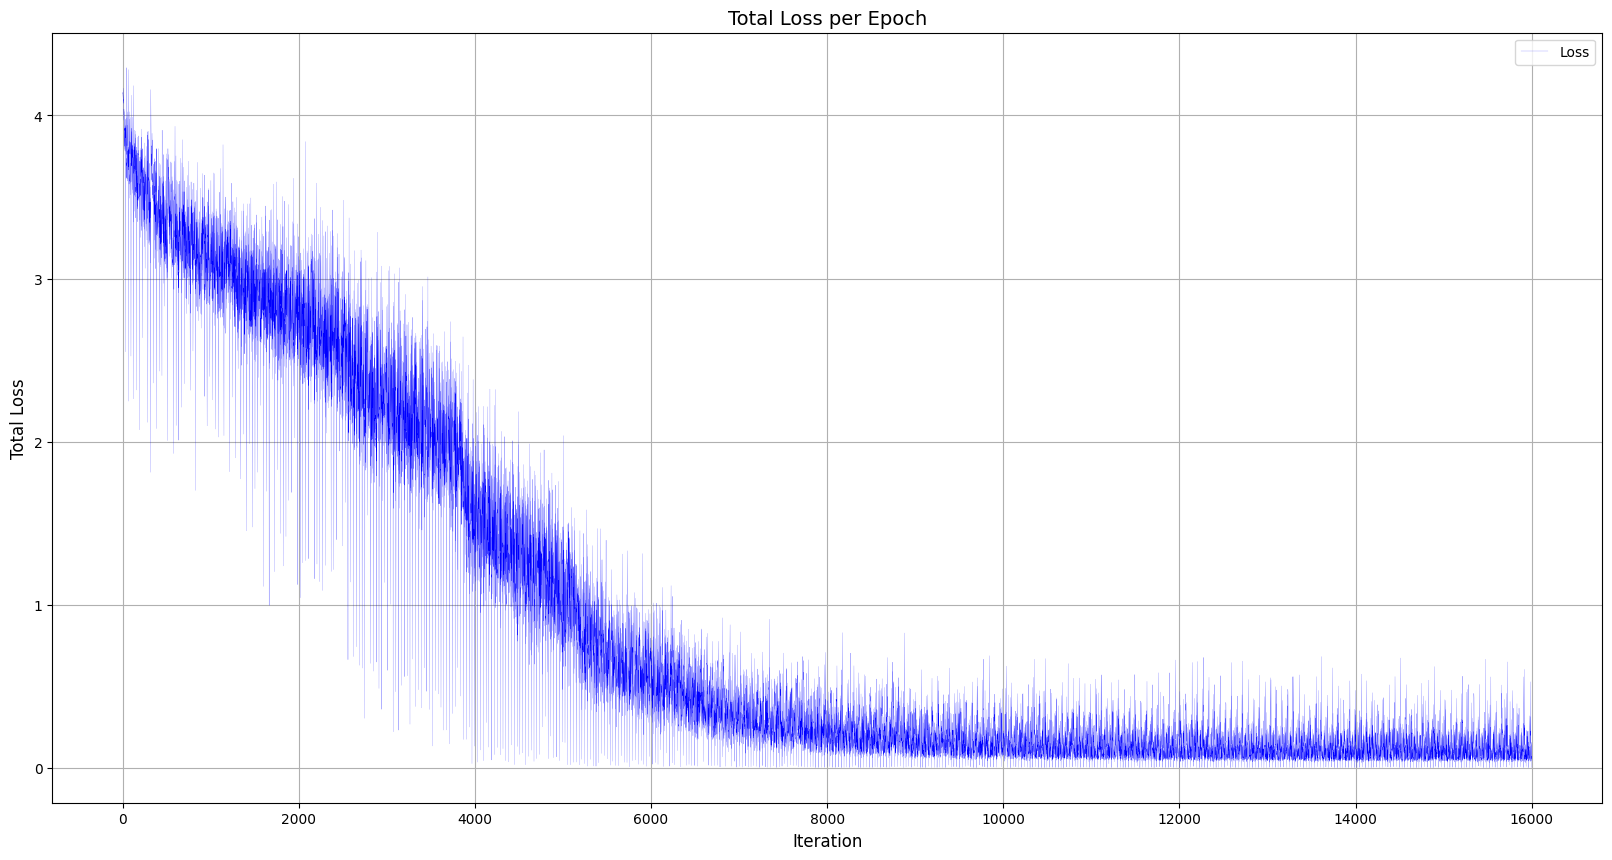

In [31]:
import matplotlib.pyplot as plt

# Plot the total losses
plt.figure(figsize=(20, 10))
plt.plot(total_losses, linestyle='-', color='b', label='Loss', linewidth=0.11)

# Adding labels, title, and legend
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Total Loss per Epoch', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Display the plot
plt.show()